In [1]:
import Pkg
Pkg.activate("../../Tasks2D")

  Activating project at `~/Developer/research/summer2023/tasks2d/Tasks2D`


In [2]:
using Revise

In [3]:
using Plots

[ Info: Precompiling IJuliaExt [2f4121a4-3b3a-5ce6-9c5e-1f2673ce168a]
ERROR: LoadError: ArgumentError: Package IJulia [7073ff75-c697-5162-941a-fcdaad2a7d2a] is required but does not seem to be installed:
 - Run `Pkg.instantiate()` to install all recorded dependencies.

Stacktrace:
 [1] _require(pkg::Base.PkgId, env::String)
   @ Base ./loading.jl:1739
 [2] _require_prelocked(uuidkey::Base.PkgId, env::String)
   @ Base ./loading.jl:1625
 [3] macro expansion
   @ ./loading.jl:1613 [inlined]
 [4] macro expansion
   @ ./lock.jl:267 [inlined]
 [5] require(into::Module, mod::Symbol)
   @ Base ./loading.jl:1576
 [6] include
   @ ./Base.jl:457 [inlined]
 [7] include_package_for_output(pkg::Base.PkgId, input::String, depot_path::Vector{String}, dl_load_path::Vector{String}, load_path::Vector{String}, concrete_deps::Vector{Pair{Base.PkgId, UInt128}}, source::Nothing)
   @ Base ./loading.jl:2010
 [8] top-level scope
   @ stdin:2
in expression starting at /Users/georgematheos/.julia/packages/Plots

In [4]:
import LineWorlds
const L = LineWorlds

[ Info: Precompiling LineWorlds [378ae85f-3ccf-4c92-8c74-de8c49c343b8]


LineWorlds

In [5]:
import GenPOMDPs
using Gen

[ Info: Precompiling GenPOMDPs [f88df91c-fa0e-46d7-b73d-4420684e5acb]


In [6]:
_segs, _boxes, _bb, _center, _xs, _hds, _ps, _dxs, _dhds, _us, _T = L.load_env();

In [7]:
PARAMS = (;
    map = _segs,
    orientation = π/2,
    bounding_box = L.bounding_box(_segs),
    step = (; σ = 0.2),
    obs = (;
        fov = 2π,
        n_rays = 40,
        sensor_args = (;
            w            = 5,
            s_noise      = 0.2,
            outlier      = 0.1,
            outlier_vol = 100.0,
            zmax = 100.0
        )
    )
);

In [8]:
mvuniform = L.ProductDistribution(uniform);
@gen (static) function uniform_agent_pos(params)
    w = params.map # a map, represented as list of line segments
    
    mins, maxs = PARAMS.bounding_box
    pos ~ mvuniform(mins, maxs)
    
    return pos
end
@load_generated_functions()

In [9]:
pos0 = uniform_agent_pos(PARAMS)

2-element Vector{Float64}:
 18.377661298317427
 14.272572021991984

In [159]:
# The next position, under a 0-noise model, with no walls.
function det_next_pos((x, y), a)
    a == :up    ? [x, y + 1] :
    a == :down  ? [x, y - 1] : 
    a == :left  ? [x - 1, y] :
    a == :right ? [x + 1, y] :
    a == :stay  ? [x, y]     :
                error("Unrecognized action: $a")
end

# Given the old pos and a new pose the agent would move to
# in absense of walls -- find where the agent did move to,
# given that it can't pass through walls.
# Specificallly -- if the agent would have to pass
# through a wall to do this, don't move it.
# [TODO: have the agent move to the intersection point
# if it tries to go through a wall.]
function handle_wall_intersection(prev, new, walls)
    move = L.Segment(prev, new)
    for wall in walls
        do_intersect, dist = L.Geometry.cast(move, wall)
        if do_intersect && dist ≤ L.Geometry.norm(move)
            return prev
        end
    end
    return new
end

@gen (static) function motion_model(prev_pos, action, PARAMS)
    np = det_next_pos(prev_pos, action)
    noisy_next_pos ~ broadcasted_normal(np, PARAMS.step.σ)
    
    next_pos = handle_wall_intersection(prev_pos, noisy_next_pos, PARAMS.map)
    
    return next_pos
end
@load_generated_functions()

In [160]:
tr = simulate(motion_model, (pos0, :left, PARAMS));
get_choices(tr)

│
└── :noisy_next_pos : [17.47568388840851, 14.19384043417068]


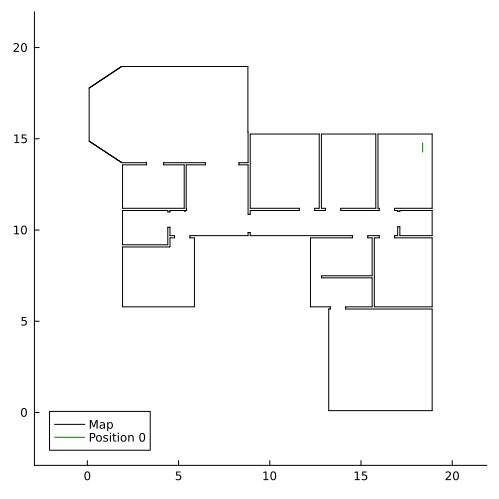

In [161]:
mypl = plot(size=(500,500), aspect_ratio=:equal, grid=false,
xlim=(_bb[1][1]-3, _bb[2][1]+3),
ylim=(_bb[1][2]-3, _bb[2][2]+3),
legend=:bottomleft,
)
plot!(_segs, c=:black, linewidth=1, label="Map")
plot!(L.Pose(pos0, PARAMS.orientation), c=:green, label="Position 0")

In [183]:
### Observation Model ###

gm             = HomogeneousMixture(L.diagnormal, [1, 1])
outlier_dist   = L.diagnormal
sensor_mix     = HeterogeneousMixture([gm, outlier_dist])
sensor_product = L.ProductDistribution(sensor_mix)

@gen function sensor_model(pos, params)
    p = L.Pose(pos, params.orientation)
    
    w, s_noise, outlier, outlier_vol, zmax = params.obs.sensor_args
    
    segs = L.stack(Vector.(params.map))
    _as = L.create_angles(params.obs.fov, params.obs.n_rays)
    zs = reshape(L.cast(Vector(p), _as, segs; zmax)[1], (1, :))
    ỹ  = L.get_2d_mixture_components(zs, _as, w)[1,:,:,:]
    
    # Observe a list of points, in the agent's coordinate frame.
    obs ~ L.sensordist_2dp3(ỹ, s_noise, outlier, outlier_vol)  
    
    return obs
end;
@load_generated_functions

In [184]:
str = simulate(sensor_model, ([5., 17.], PARAMS));
Gen.get_score(str)

NaN

In [163]:
obspts = sensor_model(pos0, PARAMS);

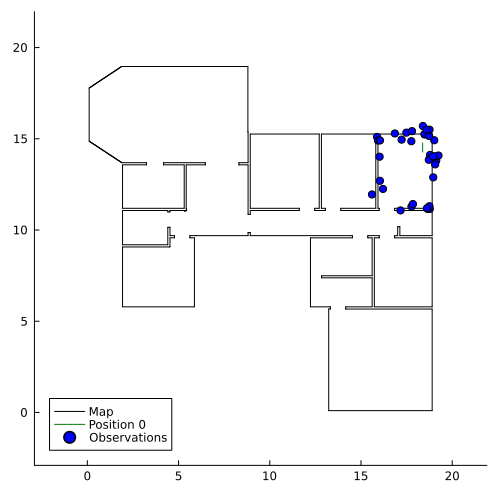

In [164]:
mypl = plot(size=(500,500), aspect_ratio=:equal, grid=false,
xlim=(_bb[1][1]-3, _bb[2][1]+3),
ylim=(_bb[1][2]-3, _bb[2][2]+3),
legend=:bottomleft,
)
plot!(_segs, c=:black, linewidth=1, label="Map")
plot!(L.Pose(pos0, PARAMS.orientation), c=:green, label="Position 0")
scatter!(obspts.*L.Pose(pos0, PARAMS.orientation), c=:blue, label="Observations")

In [165]:
# POMDP of this environment
pomdp = GenPOMDPs.GenPOMDP(
    uniform_agent_pos,       # INIT   : params                      ⇝ state
    motion_model,            # STEP   : prev_state, actions, params ⇝ state
    sensor_model,            # OBS    : state, params               ⇝ observation
    (state, action) -> 0.    # UTILITY: state, action, params       → utility
)

GenPOMDPs.GenPOMDP(var"##StaticGenFunction_uniform_agent_pos#306"(Dict{Symbol, Any}(), Dict{Symbol, Any}()), var"##StaticGenFunction_motion_model#2109"(Dict{Symbol, Any}(), Dict{Symbol, Any}()), DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any, Any], false, Union{Nothing, Some{Any}}[nothing, nothing], var"##sensor_model#2119", Bool[0, 0], false), var"#218#219"())

In [166]:
# Generative function over trajectories of the POMDP,
# given a fixed action sequence.
trajectory_model = GenPOMDPs.ControlledTrajectoryModel(pomdp)

GenPOMDPs.var"##StaticGenFunction__ControlledTrajectoryModel#2185"(Dict{Symbol, Any}(), Dict{Symbol, Any}())

In [167]:
@load_generated_functions()

In [168]:
a = (x=1, b=2)
c = (a..., x=3)

(x = 3, b = 2)

In [169]:
PARAMS2 = (PARAMS..., obs=(
                PARAMS.obs...,
                sensor_args = (;
                    w            = 5,
                    s_noise      = 0.01,
                    outlier      = 0.000001,
                    outlier_vol = 100.0,
                    zmax = 100.0
                ),
                n_rays=360
            )
        );
tr = generate(trajectory_model, (
        15,
        [
            :down, :down,
            :right, :right,
            :down, :down, :down, :down,
            :down, :right, :right, :right, :right,
            :down, :down, :right, :right
        ],
        PARAMS,
    ), choicemap((GenPOMDPs.state_addr(0, :pos), [5., 17.]))
)[1];

In [170]:
poses = [
    L.Pose(position, PARAMS.orientation)
    for position in GenPOMDPs.state_sequence(tr)
];
ptclouds = [
    obss[:obs].*pose
    for (obss, pose) in zip(
        GenPOMDPs.observation_sequence(tr),
        poses
    )
];

[ Info: Saved animation to /Users/georgematheos/Developer/research/summer2023/tasks2d/notebooks_messy/lineworld/tmp.gif


Plots.AnimatedGif("/Users/georgematheos/Developer/research/summer2023/tasks2d/notebooks_messy/lineworld/tmp.gif")
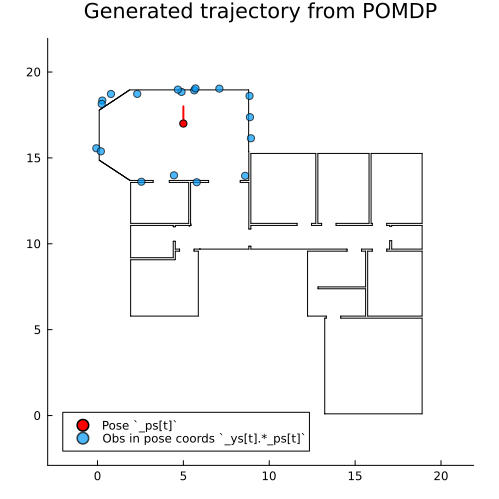

In [171]:
using Random
# -----------------------
col = palette(:default)
ani = Animation()
for t=1:1:length(poses)
    p = poses[t]
    y = ptclouds[t]

    agent_plt = plot(
        size=(500,500), aspect_ratio=:equal, title="Generated trajectory from POMDP", grid=false,
        xlim=(_bb[1][1]-3, _bb[2][1]+3),
        ylim=(_bb[1][2]-3, _bb[2][2]+3),
        legend=:bottomleft,
    )
    plot!(_segs, c=:black, linewidth=1, label=nothing)
    plot!([p], c=:red, r=1.0, linewidth=2, label=nothing)
    scatter!([p.x], c=:red, label="Pose `_ps[t]`")
    scatter!(Random.shuffle(y[1:2:end]), c=col[1], markersize=4, alpha=.7, markerstrokewidth=1, label="Obs in pose coords `_ys[t].*_ps[t]`")

    frame(ani, agent_plt)
end
# gif(ani, "_imgs/loc_data_gen.gif", fps=2) # gif(ani, fname, fps=10)
gif(ani, fps=3)

[ Info: Saved animation to /Users/georgematheos/Developer/research/summer2023/tasks2d/notebooks_messy/lineworld/tmp.gif


Plots.AnimatedGif("/Users/georgematheos/Developer/research/summer2023/tasks2d/notebooks_messy/lineworld/tmp.gif")
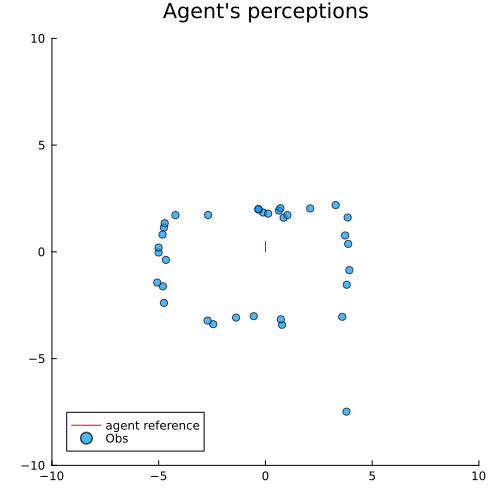

In [172]:
using Random
# -----------------------
col = palette(:default)
ani = Animation()
for t=1:1:length(poses)
    p = poses[t]

    agent_plt = plot(
        size=(500,500), aspect_ratio=:equal, title="Agent's perceptions", grid=false,
        xlim=(-10, 10),
        ylim=(-10, 10),
        legend=:bottomleft,
    )
    plot!(L.Pose([0, 0], π/2), c=:red, label="agent reference")
    scatter!(Random.shuffle(
            GenPOMDPs.observation_sequence(tr)[t][:obs][1:1:end] .* L.Pose([0, 0], π/2)
        ), c=col[1], markersize=4, alpha=.7, markerstrokewidth=1, label="Obs")

    frame(ani, agent_plt)
end
# gif(ani, "_imgs/loc_data_gen.gif", fps=2) # gif(ani, fname, fps=10)
gif(ani, fps=3)

In [173]:
@gen function pose_drift_proposal(tr, x_noise)
    T, = get_args(tr)
    pos  = tr[GenPOMDPs.state_addr(T)]

    {GenPOMDPs.state_addr(T, :noisy_next_pos)} ~ L.diagnormal(pos, [x_noise, x_noise])
    
    tr
end;

In [174]:
import GenParticleFilters
(pf_init, pf_step) = GenPOMDPs.pf(
    pomdp, PARAMS,
    (100,), # particles
    (); # bootstrap update
    post_update = (state -> begin
        GenParticleFilters.pf_rejuvenate!(
            state, Gen.mh, (pose_drift_proposal, (0.1,)), 5)
        end # begin
    )
);

In [175]:
obs0 = GenPOMDPs.observation_sequence(tr)[1]

│
└── :obs : [[-3.418140727052041, -0.7777291679019961], [-3.159082164124055, -0.7220314922812929], [Inf, Inf], [-7.484824043645548, -3.7970825479993375], [-0.8565357387482808, -3.931460647230631], [-1.5408049471260306, -3.8098851819778665], [0.37215859501410736, -3.87562921841527], [Inf, Inf], [-3.0416197086716257, -3.598046107847237], [Inf, Inf], [1.6083751472732528, -3.851839471820865], [0.7679109097891358, -3.7318239629740284], [2.0454946408157464, -0.7044608229899634], [1.5991366653592425, -0.854061098188335], [2.032801370607704, -2.095893973832351], [2.189857995050359, -3.2896239544532735], [1.9768947327154902, 0.32111213458416743], [1.7215717915637985, -1.0314972322690115], [1.8414277804052308, 0.10667260246624238], [1.789594996244377, -0.1253791623633627], [1.9324342150093223, -0.6344059161526414], [2.009407349323721, 0.3296508221845882], [1.7220432147551579, 4.214734203947731], [0.808176333116946, 4.818612327043013], [1.725887752903697, 2.6862335138178763], [-0.378182125517304

In [176]:
length(obs0[:obs])

40

In [177]:
states = []
state = pf_init(GenPOMDPs.observation_sequence(tr)[1]);
push!(states, state)
for (a, obs) in zip(
        GenPOMDPs.action_sequence(tr)[2:end],
        GenPOMDPs.observation_sequence(tr)[2:end]
    )
    state = pf_step(state, a, obs)
    push!(states, state)
end
;

[ Info: Saved animation to /Users/georgematheos/Developer/research/summer2023/tasks2d/notebooks_messy/lineworld/tmp.gif


Plots.AnimatedGif("/Users/georgematheos/Developer/research/summer2023/tasks2d/notebooks_messy/lineworld/tmp.gif")
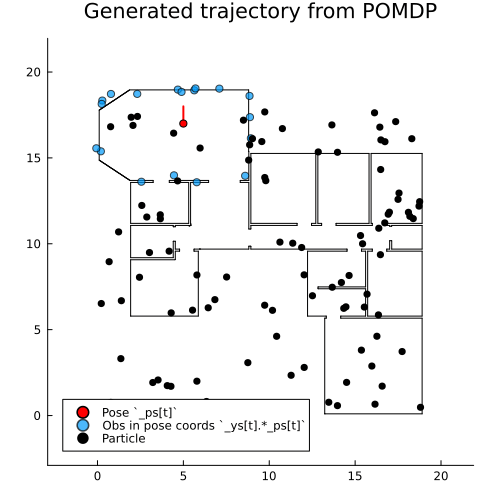

In [178]:
using Random
# -----------------------
col = palette(:default)
ani = Animation()
for t=1:1:length(poses)-1
    p = poses[t]
    y = ptclouds[t]

    agent_plt = plot(
        size=(500,500), aspect_ratio=:equal, title="Generated trajectory from POMDP", grid=false,
        xlim=(_bb[1][1]-3, _bb[2][1]+3),
        ylim=(_bb[1][2]-3, _bb[2][2]+3),
        legend=:bottomleft,
    )
    plot!(_segs, c=:black, linewidth=1, label=nothing)
    plot!([p], c=:red, r=1.0, linewidth=2, label=nothing)
    scatter!([p.x], c=:red, label="Pose `_ps[t]`")
    scatter!(Random.shuffle(y[1:2:end]), c=col[1], markersize=4, alpha=.7, markerstrokewidth=1, label="Obs in pose coords `_ys[t].*_ps[t]`")

    particles = states[t + 1]
    labeled=false
    for (w, tr) in zip(
            GenParticleFilters.get_norm_weights(particles),
            GenParticleFilters.get_traces(particles)
        )
        pos = tr[GenPOMDPs.state_addr(t)]
        if !labeled
            scatter!([pos], color=RGBA(0, 0, 0, sqrt(w)), label="Particle")
            labeled=true
        else
            scatter!([pos], color=RGBA(0, 0, 0, sqrt(w)), label=nothing)
        end
    end
    
    frame(ani, agent_plt)
end
# gif(ani, "_imgs/loc_data_gen.gif", fps=2) # gif(ani, fname, fps=10)
gif(ani, fps=3)

In [180]:
GenParticleFilters.get_norm_weights(states[1])

100-element Vector{Float64}:
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
   ⋮
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN

In [131]:
get_submap(get_choices(tr_), GenPOMDPs.obs_addr(0))

│
└── :obs : [[-3.182098146151025, -0.5606932784534757], [-7.432987017671183, -3.8848389896075077], [-2.5486132182452277, -3.3422915442814034], [Inf, Inf], [-5.1188947836791545, -3.816544143822254], [-3.24762815185344, -0.25013892635023904], [-0.44334019142734854, -4.093556098971365], [-1.2024801118001582, -3.4463016933385804], [-7.361732766706908, -3.922909147083936], [-2.690851390551076, -3.8872728730253496], [1.7982041502188746, -3.709973024098262], [-2.3266364956590895, -3.869182708788424], [2.157058239124738, -1.1535361059752152], [1.549261162329806, -1.164357008865165], [Inf, Inf], [1.7238822161198277, -0.16068259855525935], [2.1168034129146958, -0.828558642650831], [1.7573056447817157, -3.669782132879707], [1.9535908946054517, -1.0022505202510177], [1.811209390616762, -0.11306890448720813], [1.9277467269070498, -0.03495635274034278], [2.307126617122129, 0.3823345317241621], [1.7772874138721448, -0.13556540137555], [1.9620772458132743, 1.5684703175723924], [1.5530280372359004, 2.

In [134]:
tr_ = GenParticleFilters.get_traces(states[1])[1]
pos = tr_[GenPOMDPs.state_addr(0)]
obspts = get_submap(get_choices(tr_), GenPOMDPs.obs_addr(0))[:obs]
assess(
    sensor_model,
    (pos, PARAMS),
    get_submap(get_choices(tr_), GenPOMDPs.obs_addr(0))
)

(NaN, [[-3.182098146151025, -0.5606932784534757], [-7.432987017671183, -3.8848389896075077], [-2.5486132182452277, -3.3422915442814034], [Inf, Inf], [-5.1188947836791545, -3.816544143822254], [-3.24762815185344, -0.25013892635023904], [-0.44334019142734854, -4.093556098971365], [-1.2024801118001582, -3.4463016933385804], [-7.361732766706908, -3.922909147083936], [-2.690851390551076, -3.8872728730253496]  …  [0.1520897841338586, 4.922635631801193], [Inf, Inf], [-5.699505505056764, 2.0605298304916952], [Inf, Inf], [-5.516878873381515, 1.8959407480414177], [Inf, Inf], [-3.7136981880391997, 2.022496447729817], [-5.702764097084063, 2.067089310507259], [-5.861351706302938, 1.8372662486824063], [Inf, Inf]])

NaN

NaN

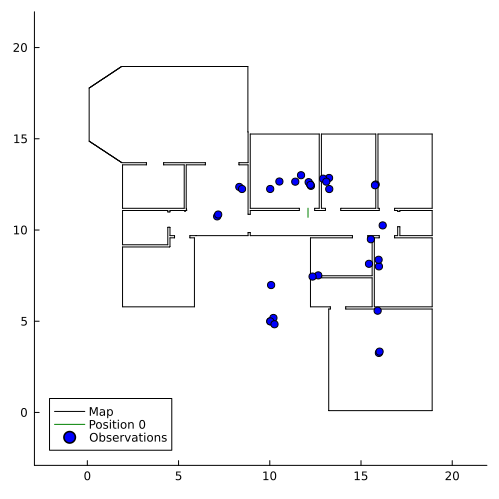

In [135]:
mypl = plot(size=(500,500), aspect_ratio=:equal, grid=false,
xlim=(_bb[1][1]-3, _bb[2][1]+3),
ylim=(_bb[1][2]-3, _bb[2][2]+3),
legend=:bottomleft,
)
plot!(_segs, c=:black, linewidth=1, label="Map")
plot!(L.Pose(pos, PARAMS.orientation), c=:green, label="Position 0")
scatter!(obspts.*L.Pose(pos, PARAMS.orientation), c=:blue, label="Observations")

In [121]:
?Gen.get_score

```
get_score(trace)
```

Return:

$$
\log \frac{p(t, r; x)}{q(r; x, t)}
$$

When there is no non-addressed randomness, this simplifies to the log probability $\log p(t; x)$.
